In [91]:
import gspread
from gspread_dataframe import get_as_dataframe
from oauth2client.service_account import ServiceAccountCredentials
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [8]:
scope = ["https://spreadsheets.google.com/feeds",'https://www.googleapis.com/auth/spreadsheets',"https://www.googleapis.com/auth/drive.file","https://www.googleapis.com/auth/drive"]

In [9]:
creds = ServiceAccountCredentials.from_json_keyfile_name("creds.json", scope)
client = gspread.authorize(creds)

In [10]:
#spreadsheets with different dates placed in separate worksheets
spreadsheet_old = client.open_by_url("https://docs.google.com/spreadsheets/d/1yZv9w9zRKwrGTaR-YzmAqMefw4wMlaXocejdxZaTs6w/edit#gid=638231677")
spreadsheet = client.open_by_url("https://docs.google.com/spreadsheets/d/1wQVypefm946ch4XDp37uZ-wartW4V7ILdg-qYiDXUHM/htmlview?usp=sharing&sle=true")
#spreadsheet with 3 worksheets - Confirmed, Deaths, Recovered - columns are dates
spreadsheet_time_series = client.open_by_url("https://docs.google.com/spreadsheets/d/1UF2pSkFTURko2OvfHWWlFpDFAr1UxCBA4JLwlSP6KFo/htmlview?usp=sharing&sle=true")

In [30]:
### lists and dicts to help clear dataframes
#list of columns i want to keep
const_cols = ["Province/State", "Country", "Country/Region", "Date last updated", "Last Update", "Confirmed", "Recovered", "Deaths"]
#dict of column names to change
column_names = {"Country": "Country/Region", "Date last updated": "Last Update"}
#dict of columns and values to put in NaNs
fillna_values = {'Province/State': "", "Country/Region": "", "Confirmed": 0, "Recovered": 0, "Deaths":0}

In [12]:
#lists with worksheets
list_dates = spreadsheet.worksheets()
list_time_series = spreadsheet_time_series.worksheets()

In [42]:
#list to help change column names
list_of_column_names = []

def read_spreadsheets(spreadsheet, list_dates,save):
    titles = []
    df_list = []

    for df in list_dates:
        #get worksheet as df
        title = df.title
        titles.append(title)
        df = get_as_dataframe(spreadsheet.worksheet(title))
        # delete columns i don't need
        for col in df.columns:
            if not col in const_cols:
                df = df.drop(labels=col, axis=1)
        #get column names that stayed in list of dfs
#         for col in df.columns:
#             if not col in list_of_column_names:
#                 list_of_column_names.append(col)

        #drop columns and rows with only NaNs
        df = df.dropna(axis=0, how='all')
        df = df.dropna(axis=1, how='all')

        # changing column names to standarise it
        df = df.rename(columns=column_names)

        #filling NaNs
        df = df.fillna(value=fillna_values)

        #adding dfs to df_list
        df_list.append(df)

    #save multiple sheets to excel
    if save == True:
        writer = pd.ExcelWriter('2019_nCoV_multiple_sheets.xlsx', engine='xlsxwriter')

        for i, df in enumerate(df_list, 0):
            df.to_excel(writer, sheet_name=titles[i], index=False)

        writer.save()

    return df_list

In [52]:
def big_df(df_list,fillna_values):
    #make df is a first date df for a start
    main_df = df_list[len(df_list) - 1]
    #adding next dfs to main_df
    for i in range(0, len(df_list) - 1):
        main_df = pd.concat([main_df, df_list[len(df_list) - 1 - i]], axis=0, ignore_index=True, sort=False)
    main_df = main_df.fillna(value=fillna_values)
    return main_df

In [43]:
def read_time_series_spreadsheets(spreadsheet_time_series,list,save):
    titles = []
    df_list = []

    for df in list:
        # get worksheet as df
        title = df.title
        titles.append(title)
        df = get_as_dataframe(spreadsheet_time_series.worksheet(title))

        df = df.dropna(axis=0, how='all')
        df = df.dropna(axis=1, how='all')

        df_text = df[df.columns[0:2]]
        df_text = df_text.fillna(value = '')
        df_val = df[df.columns[2:len(df.columns)]]
        df_val = df_val.fillna(value = 0)
        df = pd.concat([df_text,df_val],axis=1)
        df_list.append(df)

    if save == True:
        writer = pd.ExcelWriter('2019_nCoV_time_series.xlsx', engine='xlsxwriter')

        for i, df in enumerate(df_list,0):
            df.to_excel(writer,sheet_name=titles[i], index=False)

        writer.save()

    return df_list

In [44]:
df_list = read_spreadsheets(spreadsheet,list_dates,save=True)

In [45]:
time_series_df_list = read_time_series_spreadsheets(spreadsheet_time_series, list_time_series, save=True)

In [53]:
main_df = big_df(df_list,fillna_values)

In [47]:
main_df.to_excel('2019_nCoV.xlsx', sheet_name="2019_nCoV_all_data",index=False)

In [23]:
print("Shape of dataframe: {}".format(time_series_df_list[0].shape))
#printing whole df
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(time_series_df_list[0])

Shape of dataframe: (67, 33)
      Province/State        Country/Region  \
0              Anhui        Mainland China   
1            Beijing        Mainland China   
2          Chongqing        Mainland China   
3             Fujian        Mainland China   
4              Gansu        Mainland China   
5          Guangdong        Mainland China   
6            Guangxi        Mainland China   
7            Guizhou        Mainland China   
8             Hainan        Mainland China   
9              Hebei        Mainland China   
10      Heilongjiang        Mainland China   
11             Henan        Mainland China   
12             Hubei        Mainland China   
13             Hunan        Mainland China   
14    Inner Mongolia        Mainland China   
15           Jiangsu        Mainland China   
16           Jiangxi        Mainland China   
17             Jilin        Mainland China   
18          Liaoning        Mainland China   
19           Ningxia        Mainland China   
20   

In [61]:
time_series_df_list[0]

,Province/State,Country/Region,First confirmed date in country (Est.),Lat,Long,1/21/2020 10:00 PM,1/22/2020 12:00 PM,1/23/2020 12:00 PM,1/24/2020 12:00 AM,1/24/2020 12:00 PM,...,1/29/2020 9:00 PM,1/30/2020 11:00 AM,1/31/2020 2:00 PM,1/31/2020 7:00 PM,2/1/2020 10:00 AM,2/2/2020 9:00 PM,2/3/2020 9:00 PM,2/4/2020 9:40 AM,2/4/2020 10:00 PM,2/5/2020 9:00 AM
0,Anhui,Mainland China,1/3/2020,31.82571,117.22640,0.0,1.0,9.0,15.0,15.0,...,200.0,200.0,237.0,237.0,297.0,408.0,480.0,480.0,530.0,530.0
1,Beijing,Mainland China,1/3/2020,40.18238,116.41420,10.0,14.0,22.0,26.0,36.0,...,111.0,114.0,139.0,139.0,168.0,191.0,212.0,212.0,228.0,253.0
2,Chongqing,Mainland China,1/3/2020,30.05718,107.87400,5.0,6.0,9.0,27.0,27.0,...,165.0,182.0,211.0,238.0,247.0,300.0,337.0,337.0,366.0,376.0
3,Fujian,Mainland China,1/3/2020,26.07783,117.98950,0.0,1.0,5.0,5.0,10.0,...,101.0,101.0,120.0,120.0,144.0,159.0,179.0,179.0,194.0,205.0
4,Gansu,Mainland China,1/3/2020,36.06110,103.83430,0.0,0.0,2.0,2.0,2.0,...,26.0,26.0,29.0,35.0,35.0,51.0,55.0,55.0,57.0,57.0
5,Guangdong,Mainland China,1/3/2020,23.33841,113.42200,17.0,26.0,32.0,53.0,53.0,...,311.0,354.0,436.0,436.0,535.0,683.0,725.0,797.0,870.0,895.0
6,Guangxi,Mainland China,1/3/2020,23.82908,108.78810,0.0,2.0,5.0,13.0,23.0,...,78.0,78.0,87.0,88.0,100.0,127.0,139.0,139.0,150.0,150.0
7,Guizhou,Mainland China,1/3/2020,26.81536,106.87480,0.0,1.0,3.0,3.0,3.0,...,12.0,12.0,29.0,29.0,29.0,46.0,56.0,56.0,64.0,64.0
8,Hainan,Mainland China,1/3/2020,19.19673,109.74550,0.0,4.0,5.0,8.0,8.0,...,43.0,46.0,52.0,58.0,62.0,71.0,79.0,79.0,91.0,91.0
9,Hebei,Mainland China,1/3/2020,38.04280,114.51490,0.0,1.0,1.0,2.0,2.0,...,65.0,65.0,82.0,96.0,96.0,113.0,126.0,126.0,135.0,135.0


In [107]:
#
china_confirmed_series = time_series_df_list[0][time_series_df_list[0]['Country/Region']=="Mainland China"].iloc[:,5:].sum(axis=0)
print(china_confirmed_series)

1/21/2020 10:00 PM      325.0
1/22/2020 12:00 PM      547.0
1/23/2020 12:00 PM      639.0
1/24/2020 12:00 AM      865.0
1/24/2020 12:00 PM      916.0
1/25/2020 12:00 AM     1320.0
1/25/2020 12:00 PM     1399.0
1/25/2020 10:00 PM     1979.0
1/26/2020 11:00 AM     2062.0
1/26/2020 11:00 PM     2737.0
1/27/2020 9:00 AM      2825.0
1/27/2020 7:00 PM      2863.0
1/27/2020 8:30 PM      4409.0
1/28/2020 1:00 PM      4610.0
1/28/2020 6:00 PM      5494.0
1/28/2020 11:00 PM     5970.0
1/29/2020 1:30 PM      6070.0
1/29/2020 2:30 PM      6070.0
1/29/2020 9:00 PM      7678.0
1/30/2020 11:00 AM     8124.0
1/31/2020 2:00 PM      9783.0
1/31/2020 7:00 PM     11221.0
2/1/2020 10:00 AM     11860.0
2/2/2020 9:00 PM      17114.0
2/3/2020 9:00 PM      20014.0
2/4/2020 9:40 AM      20400.0
2/4/2020 10:00 PM     24290.0
2/5/2020 9:00 AM      24391.0
dtype: float64


In [108]:
dates = china_confirmed_series.index.values
dates_datetime = pd.to_datetime(dates, format="%m/%d/%Y %I:%M %p")
print(dates_datetime)

DatetimeIndex(['2020-01-21 22:00:00', '2020-01-22 12:00:00',
               '2020-01-23 12:00:00', '2020-01-24 00:00:00',
               '2020-01-24 12:00:00', '2020-01-25 00:00:00',
               '2020-01-25 12:00:00', '2020-01-25 22:00:00',
               '2020-01-26 11:00:00', '2020-01-26 23:00:00',
               '2020-01-27 09:00:00', '2020-01-27 19:00:00',
               '2020-01-27 20:30:00', '2020-01-28 13:00:00',
               '2020-01-28 18:00:00', '2020-01-28 23:00:00',
               '2020-01-29 13:30:00', '2020-01-29 14:30:00',
               '2020-01-29 21:00:00', '2020-01-30 11:00:00',
               '2020-01-31 14:00:00', '2020-01-31 19:00:00',
               '2020-02-01 10:00:00', '2020-02-02 21:00:00',
               '2020-02-03 21:00:00', '2020-02-04 09:40:00',
               '2020-02-04 22:00:00', '2020-02-05 09:00:00'],
              dtype='datetime64[ns]', freq=None)


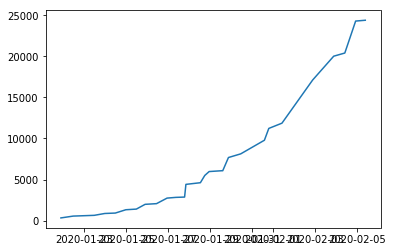

In [109]:
plt.plot(dates_datetime, china_confirmed_series)